In [1]:
using HTTP, JSON, PrettyTables, JLD, DotEnv, WordCloud, Random
DEBUG_LEVEL = 1
#if you want a list of universities in each tier set this to true
show_tier_members = false
include("functions/type_allocation_flexible.jl")
public_sector = ("Public Sector", Set())
private_sector = ("Private Sector", Set())
other_groups = ("Other Groups", Set())
postdocs = ("Postdocs", Set())
lecturers = ("Lecturers", Set())
other_academic = ("Other Academic", Set())
unmatched = ("Unmatched", Set())
# choose the number of academic types
NUMBER_OF_TYPES = 5
# choose which of the sets declared above your want to include in the classification
sinks_to_include = (public_sector, private_sector,postdocs,lecturers,unmatched, other_groups);
# teaching universities are discovered by finding institutions that hire but  never graduate, so they are added automatically
NUMBER_OF_SINKS = length(sinks_to_include)+1
numtotal = NUMBER_OF_TYPES + NUMBER_OF_SINKS
cfg = DotEnv.config(path="../.env")
files_path = cfg["files_path"]

"/home/peters/code/mapinator/estimation/current_estimates_and_files/"

In [2]:
# designed to fetch data from disk
# currently run mike_assemble_data.ipynb to refresh data from the api source
to_from_by_year_api = SBM_flexible.fetch_data(files_path*"to_from_by_year.json");

In [3]:
academic, academic_to, academic_builder, rough_sink_builder, institution_mapping, reverse_mapping = SBM_flexible.get_builders(to_from_by_year_api);

In [4]:
# sink of teaching universities that do not graduate PhDs
# this must be constructed using academic placements, not pre-defined sink placements

teaching_universities = Set() 
for dept_name in academic_to
    if !(dept_name in academic)
        # the department hired an assistant professor but never graduated anyone
        push!(teaching_universities, dept_name)
    end
end
println(length(teaching_universities))

599


In [5]:

for outcome in rough_sink_builder
    if outcome["disappeared"] == 1 #untrackable applicants
        push!(unmatched[2], (string(outcome["to_name"], " ($(unmatched[1]))"), outcome))
    elseif outcome["recruiter_type"] == 5 # government institution
        push!(public_sector[2], (string(outcome["to_name"], " ($(public_sector[1]))"), outcome))
    elseif outcome["recruiter_type"] in [6, 7] # private sector: for and not for profit
        push!(private_sector[2], (string(outcome["to_name"], " ($(private_sector[1]))"), outcome))
    elseif outcome["recruiter_type"] == 8 # international organizations, think tanks, assorted
        push!(other_groups[2], (string(outcome["to_name"], " ($(other_groups[1]))"), outcome))

    # some other examples
    # every example here must also have a corresponding sink Set() above, 
    #     and an entry in sinks_to_include below
   
    elseif outcome["postype"] == 6
        # postdocs that are not in the above (i.e. academic; not public, private, or other)
        # requires reconfiguration of the to_from_by_year loading code
        push!(postdocs[2], (string(outcome["to_name"], " ($(postdocs[1]))"), outcome))
    elseif outcome["postype"] in [5, 7]
        # lecturers that are not in the above
        # requires reconfiguration of the to_from_by_year loading code
        push!(lecturers[2], (string(outcome["to_name"], " ($(lecturers[1]))"), outcome))
    else
        # everything else including terminal academic positions
        # this sink can only be constructed as an "else" statement
        push!(other_academic[2], (string(outcome["to_name"], " ($(other_academic[1]))"), outcome))
    
    end
end

# sort to ensure consistent ordering
academic_list = sort(collect(academic))
teaching_list = sort(collect(teaching_universities))
# to be consistent with the original estimation, we only include these additional sinks:


sink_builder, sinks, sink_labels = SBM_flexible.build_sinks(sinks_to_include, teaching_list)

institutions = vcat(academic_list, sinks...)
println("$(length(academic_list)) academic departments, $(length(institutions)) total departments")

Including the following sinks:
 Public Sector
 Private Sector
 Postdocs
 Lecturers
 Unmatched
 Other Groups
 Teaching Universities
Total 7 sinks
1028 academic departments, 2928 total departments


In [30]:
println(length(academic_builder) + length(sink_builder))
sink_labels

15080


8-element Vector{Any}:
 "Public Sector"
 "Private Sector"
 "Postdocs"
 "Lecturers"
 "Unmatched"
 "Other Groups"
 "Teaching Universities"
 "Column Totals"

In [7]:
out = SBM_flexible.get_adjacency(academic_list, institutions, academic_builder, sink_builder);

Total 15080 Placements (found 15080 by sequence counting, 15080 by matrix sum)


In [8]:
using Optim, Random
Random.seed!(0)

TaskLocalRNG()

In [9]:
function β(K, likelihoods, λ, numtotal_test, n)
    return likelihoods[K] - λ * ((K * numtotal_test) / 2) * n * log(n)
end

function w(β_vec)
    return β_vec ./ sum(β_vec)
end

function objective_to_minimize(λ_vec, range_K, likelihoods, numsink, n)
    λ = λ_vec[1] # just 1-D
    if λ < 0 
        return Inf 
    end
    w_vec = w([β(K, likelihoods, λ, K + numsink, n) for K in range_K])
    return sum(w_vec .* log.(w_vec))
end

objective_to_minimize (generic function with 1 method)

In [10]:
Random.seed!(0) # for reproducibility
@time est_obj, est_alloc = SBM_flexible.doit(out, length(academic_list), [length(s) for s in sinks], NUMBER_OF_TYPES, numtotal, 500 * (NUMBER_OF_TYPES-2) + 1000)

483.891381 seconds (393.15 k allocations: 20.498 MiB, 0.02% compilation time)


(49339.96689438602, Int32[5, 5, 3, 4, 4, 4, 4, 5, 5, 4  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [11]:
placement_rates, counts, sorted_allocation, full_likelihood = SBM_flexible.get_allocation(est_alloc, out, NUMBER_OF_TYPES, numtotal, institutions)

(Int32[594 88 … 4 3; 646 358 … 26 5; … ; 380 428 … 278 187; 357 562 … 280 159], Int32[361 969 … 5947 9234; 969 2601 … 15963 24786; … ; 684 1836 … 11268 17496; 11381 30549 … 187487 291114], Int32[4, 4, 3, 5, 5, 5, 5, 4, 4, 5  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12], -68760.69202709672)

In [34]:
# define row titles for the adjacency matrix, include institution counts
names = []
for i in 1:NUMBER_OF_TYPES + NUMBER_OF_SINKS
    if i <= NUMBER_OF_TYPES
        push!(names,string("TYPE ", i, " (", counter[i]," insts)"))
    else
        push!(names, string(sink_labels[i - NUMBER_OF_TYPES], " (", counter[i]," insts)"))
    end
#counter\
end
SBM_flexible.nice_adjacency_table(placement_rates, names)

┌───────────────────────────────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│                                   │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Tier 5 │ Row Totals │
├───────────────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│                 TYPE 1 (19 insts) │    594 │     88 │     33 │      4 │      3 │        722 │
│                 TYPE 2 (51 insts) │    646 │    358 │    116 │     26 │      5 │       1151 │
│                TYPE 3 (159 insts) │    912 │   1013 │    458 │     62 │     15 │       2460 │
│                TYPE 4 (313 insts) │    248 │    351 │    258 │    178 │     16 │       1051 │
│                TYPE 5 (486 insts) │      0 │     15 │     20 │      0 │     49 │         84 │
│         Public Sector (141 insts) │    512 │    459 │    235 │     64 │     25 │       1295 │
│        Private Sector (200 insts) │    666 │    340 │    201 │     49 │     28 │       1284 │
│              Postdocs (555 insts) │   

In [14]:
type_dictionary = []
for (i, alloc) in enumerate(sorted_allocation)
    if alloc in 1:NUMBER_OF_TYPES
        inst_id = reverse_mapping[institutions[i]]
        push!(type_dictionary, Dict("name" => institutions[i], "institution_id" => inst_id, "type" => alloc))
    end
end

In [15]:
open(files_path*"id_to_type_api.json", "w") do f
    write(f, JSON.json(type_dictionary))
end;

In [16]:
counter = zeros(Int64,NUMBER_OF_TYPES+NUMBER_OF_SINKS);

In [17]:

for sorted_type in 1:NUMBER_OF_TYPES+NUMBER_OF_SINKS
    #counter = 0
    inst_hold = []
    println("TYPE $sorted_type:")
    for (i, sbm_type) in enumerate(sorted_allocation)
        if sbm_type == sorted_type
            push!(inst_hold, institutions[i])
            counter[sorted_type] += 1
        end
    end
    if show_tier_members
        for inst in sort(inst_hold)
        println("  ", inst)
        end
    end
    println("Total Institutions: ",counter[sorted_type])
    println()
end

TYPE 1:
Total Institutions: 19

TYPE 2:
Total Institutions: 51

TYPE 3:
Total Institutions: 159

TYPE 4:
Total Institutions: 313

TYPE 5:
Total Institutions: 486

TYPE 6:
Total Institutions: 141

TYPE 7:
Total Institutions: 200

TYPE 8:
Total Institutions: 555

TYPE 9:
Total Institutions: 368

TYPE 10:
Total Institutions: 1

TYPE 11:
Total Institutions: 36

TYPE 12:
Total Institutions: 599



In [27]:
SBM_flexible.nice_adjacency_table(placement_rates,names, files_path*"nice_adjacency_table.tex")

In [35]:
#save the adjacency matrix to pass on to the value estimates file
save(files_path*"/placement_rates.jld", "placement_rates", placement_rates)
save(files_path*"row_names.jld", "names", names)


Total words: 20.0. Unique words: 20. After filtration: 15.
The top 15 words are kept. 
color scheme: :tableau_blue_light, random size: 1
angles = collect(0:90)
backgroundcolor = :maskcolor
shape(box, 258, 155, cornerradius=58, color=0.0, padding=19)
fonts = "Arial Unicode MS Normal"
mask size: 193×296, volume: 192² (50²/word)
set fontsize ∈ [8.0, 193]
set density = 0.5
⋯scale=55.41585212433953, density=0.6123953217009037	↑
⋯scale=50.07293933982634, density=0.5095807440775013	↑
fontsize ∈ [9.269025319765605, 24.365537510771077]


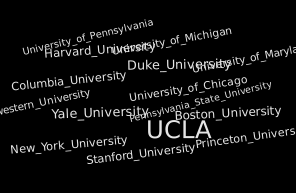

In [24]:
words = ""
weights = []

for inst in type_dictionary
    if inst["type"] == 1
        temp_word = replace(inst["name"], " " => "_")
        words = words * replace(temp_word,"," => "") * " "
        push!(weights, length(inst["name"]))
    end
end

wc = wordcloud(words)


In [25]:
generate!(wc)
paint(wc, ".estimates/type1.svg")
#words

▸1. Set spacing = 2; scale = 49.54572375914637
Completed after 61 epochs.


Total words: 54.0. Unique words: 54. After filtration: 45.
The top 45 words are kept. 
color scheme: :Spectral_5, random size: 2, shuffled
angles = [0, 45, 90]
backgroundcolor = :maskcolor
shape(box, 461, 291, cornerradius=36, color=(0.99, 0.981, 0.997), padding=36, outline=9, linecolor=RGB{Float64}(0.992,0.682,0.38))
fonts = "STSong"
mask size: 381×551, volume: 365² (54²/word)
set fontsize ∈ [8.0, 381]
set density = 0.5
⋯scale=60.75337210577057, density=0.5671547695202258	↑
⋯scale=57.043294006836, density=0.48894728127939796	↓
fontsize ∈ [10.668605997816847, 24.610277107914797]


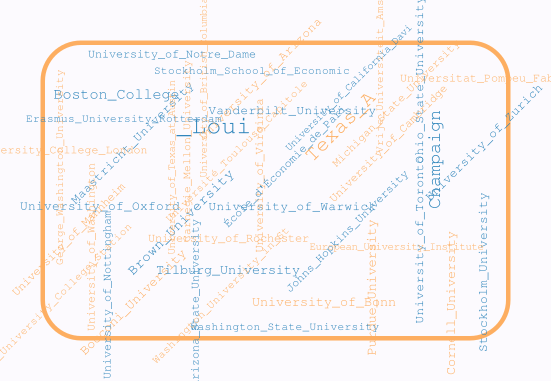

In [26]:
using WordCloud, Random
words = ""
weights = []

for inst in type_dictionary
    if inst["type"] == 2
        temp_word = replace(inst["name"], " " => "_")
        words = words * replace(temp_word,"," => "") * " "
        push!(weights, length(inst["name"]))
    end
end

wc = wordcloud(words)
